# Création du dataset, import des images, AutoEncodeur


Le but est de charger les images, pour pouvoir ensuite les traiter. Créer un AutoEncodeur pour pouvoir tester plus tard notre réseau etc ....


## Charger juste une images pour tester

Avant d'importer tout les jeu de données on regarde comment importert juste une image.
D'ailleurs **PyTorch** utilise un type spécial pour représenter les images, au lieu des matrices, il utilise les **Tenseur** (Tensor : [TorchAPI](https://pytorch.org/docs/stable/torch.html)), c'est une sorte de matrice avec plus de dimensions (CF : *[Tenseur](https://fr.wikipedia.org/wiki/Tenseur)* ). 


### Définition formelle de tenseurs :   
>Soit V un espace vectoriel de dimension n sur un corps commutatif K {\displaystyle K}. L'espace dual V* est l'espace vectoriel formé de toutes les formes linéaires définies sur V. L'espace V* est aussi de dimension n. Les éléments de V et V* sont appelés respectivement vecteurs et covecteurs.

>Un tenseur est une application multilinéaire
>$$ {\displaystyle T:\underbrace {V^{*}\times \ldots \times V^{*}} _{h}\times \underbrace {V\times \ldots \times V} _{k}\to K} $$



In [1]:
import torch
from torchvision import transforms
from PIL import Image

# Définir les transformations à appliquer aux images
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Redimensionner l'image à 256x256 pixels
    transforms.ToTensor()           # Convertir l'image en tenseur PyTorch
])

# Chemin vers l'image à charger
image_path = '0000.png'

# Charger l'image avec PIL
image = Image.open(image_path)

# Appliquer les transformations à l'image
image_tensor = transform(image)

# Ajouter une dimension pour le batch (par exemple, si vous avez une seule image)
image_tensor = image_tensor.unsqueeze(0)

# Afficher la forme du tenseur de l'image
print(image_tensor.shape)

torch.Size([1, 3, 400, 400])


## Initialiser le DataSet

Le but du code suivant est de créer le dataset des données d'netrainements, en les importants depuis le dossier
"engine_wiring/engine_wiring/train/good".
D'ailleurs dans ce dossier tout les objets sont de type **good**.
Donc on va tous les "labéliser" en le nom du sous dossier (dans notre cas **good**).


In [ ]:
#Code géneré par LeChat

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Chemin vers le répertoire contenant les images.
            transform (callable, optional): Transformations optionnelles à appliquer aux images.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = img_path.split("/")[-1]
        

        return image,label

# Définir les transformations à appliquer aux images
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Redimensionner l'image à 256x256 pixels
    transforms.ToTensor()           # Convertir l'image en tenseur PyTorch
])

# Chemin vers le répertoire contenant les images
image_dir = 'engine_wiring/engine_wiring/train/good'

# Créer une instance du dataset
dataset = CustomImageDataset(image_dir=image_dir, transform=transform)

# Créer un DataLoader pour itérer sur le dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


    

    

train


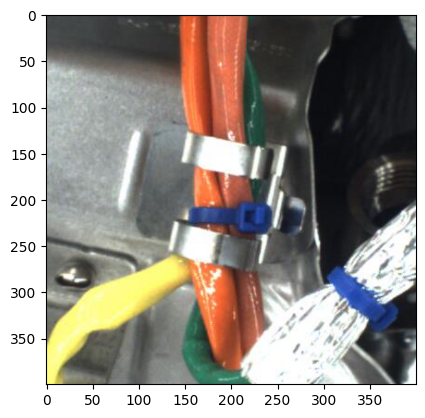

In [6]:
plt.imshow(dataset[1][0].permute(1,2,0)) # Affiche une images du dataset
print(dataset[0][1])

## AutoEncodeur (premier test avec MNIST)

Dans cette partie nous allons essayer de créer un **AutoEncodeur** simple, pour se familiariser avec PyTorch à l'aide du [Tuto](https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/), donc la taille de l'entrée est 28x28 = 784 

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

tensor_transform = transforms.ToTensor()

#Récupère le dataset, mettre download à True si les données ne sont pas présente en local.
dataset = datasets.MNIST("./data",train= True,download=False,transform=tensor_transform)

#créer l'itérateur
loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=32,shuffle=True)





#### Création de la classe principale

$Linear: x \to xA^T+b $<br>
$ReLU:  x \to max(0,x) $ <br>
$Sigmoid: x \to \frac{1}{1+e^{-x}}$

In [3]:
class AutoEncodeur(torch.nn.Module):
    def __init__(this): # j'ai mis this pour faire comme en java, mais en vrai on utilise self
        super().__init__()

        #Création d el'encodeur
        this.encodeur = torch.nn.Sequential(
            #Linear(entré, sortie) -> matrice entré x sortie
            torch.nn.Linear(28 * 28,128), # La taille de la couche
            torch.nn.ReLU(), # La fonction d'activation
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )


        this.decodeur = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid() #Sigmoid à la fin pour avori une valeur entre 0 et 1
        )


    def forward(this, x): # Le feedForward -> propagation avant
        encoded = this.encodeur(x)
        decoded = this.decodeur(encoded)
        return decoded




#### Initialisation du modèle

Utilisation de MSE : <br>
$\sum (x-e)^2$ <br>

L'optimiseur est le moyen de calculer la descente de gradient, [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)  est le plus "efficace" dans notre cas (converge le plus vite, et vers un bon minimum), il en existe d'autre la descente de gradient de base, descente de Newton, descente de gradient stochastique (CF cours de MCMC), Adam est une amélioration de la descente de gradient stochastique.

In [4]:
model = AutoEncodeur()
fonction_perte = torch.nn.MSELoss()

#lr : learning rate 
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-1, weight_decay=1e-8)

#### Génération de l'output

/!\\ attention ce code prend 20minutes + (123 minutes )

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

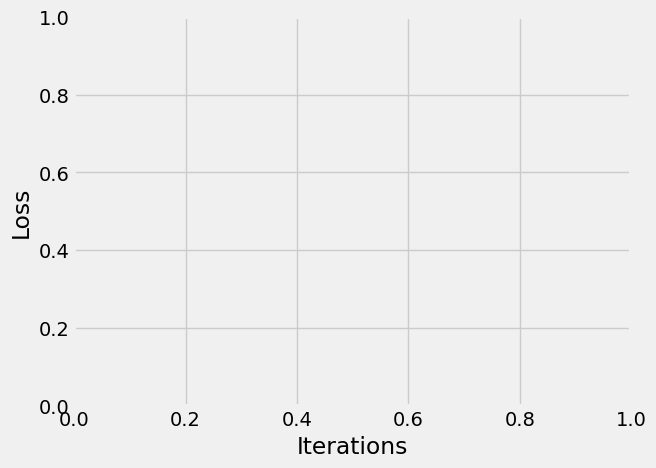

In [ ]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader: #Pour tester en batch, loader est l'itérateur du jeu de données
       
      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 28*28)
       
      # Output of Autoencoder
      reconstructed = model(image) #On calcul l'image génerer par le réseau
       
      # Calculating the loss function
      loss = fonction_perte(reconstructed, image)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      # On fait la rétropropagation du gradient
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 
       
      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, image, reconstructed))


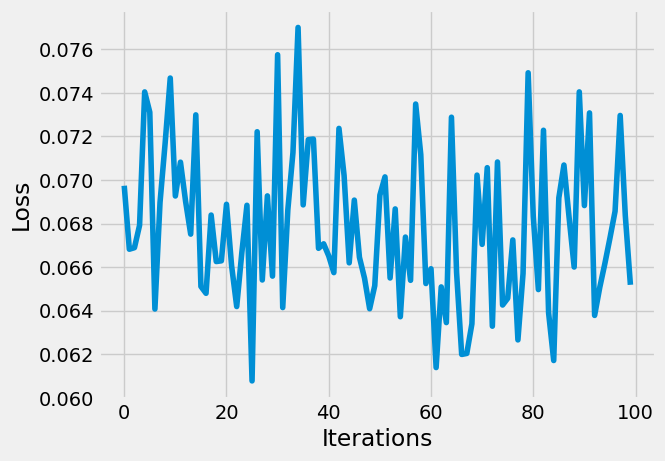

In [14]:

# On affiche la fonction perte sur les derniérs calcul
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
losses2 = []
for i in losses:
    losses2.append(i.detach().numpy())

# Plotting the last 100 values
plt.plot(losses2[-100:])

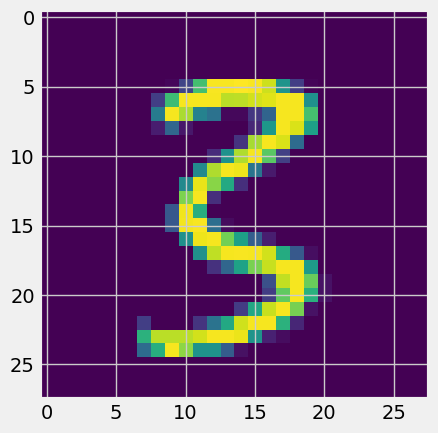

In [10]:
#pour afficher les 2 premiere image, à gauche c'elle donnée initialement, à droite c'elle généré par le réseau.
for i, item in enumerate(image):
   
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0])


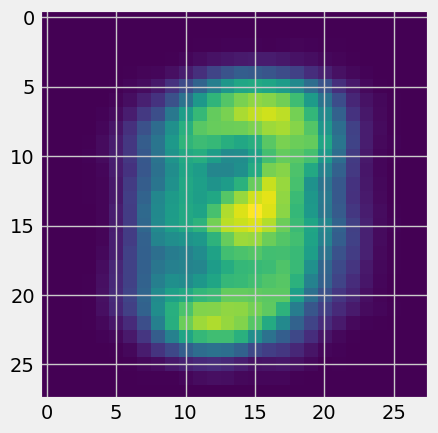

In [11]:

for i, item in enumerate(reconstructed):
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0].detach().numpy())

Cet AutoEncodeur n'est pas le plus précis, si on vuet des trucs mieux on peut faire des **couches de convolutions**, au lieu de **couche linéaires** (_Conv2d ou Conv3d_)
